<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')


In [0]:
#Setthe current date for new cells
current_date = 20200316


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
res = dfCovidtracking.loc[dfCovidtracking.date==current_date, ['positive', 'negative', 'pending', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

positive     4019
negative    35840
pending      1691
total       41552
dtype: int64
Current Infection Rate 9.672218%


In [7]:
dfCovidtracking.loc[dfCovidtracking.date==current_date,['state', 'positive']].sort_values(by='positive', ascending=False).head(10)

,state,positive
34,NY,950
47,WA,769
4,CA,335
31,NJ,178
19,MA,164
9,FL,141
5,CO,131
10,GA,121
18,LA,114
14,IL,93


In [0]:
#Compare growth from 20200311 and 202020313
dtstart = 20200315
dtend = 20200316
dfCA = dfCovidtracking[dfCovidtracking.state=='CA']

In [11]:
arCols = ['positive', 'negative', 'death']
arTotCols= ['positive', 'negative']

dfUSAstart = dfCovidtracking.loc[dfCovidtracking.date == dtstart, arCols].sum()
print(dfUSAstart)
print(dfUSAstart.loc[arTotCols].sum())
dfUSAend = dfCovidtracking.loc[dfCovidtracking.date == dtend, arCols].sum()
print(dfUSAend)
print(dfUSAend.loc[arTotCols].sum())


positive     3173
negative    22548
death          60
dtype: int64
25721
positive     4019
negative    35840
death          71
dtype: int64
39859


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [13]:
dfUSAPos

,date,positive,PCT
0,20200304,118,0.029361
1,20200305,176,0.043792
2,20200306,223,0.055486
3,20200307,341,0.084847
4,20200308,417,0.103757
5,20200309,584,0.145310
6,20200310,778,0.193580
7,20200311,1053,0.262005
8,20200312,1315,0.327196
9,20200313,1922,0.478228


In [14]:
dfCAPos

,date,positive,PCT
0,20200304,53,0.158209
1,20200305,53,0.158209
2,20200306,60,0.179104
3,20200307,69,0.205970
4,20200308,88,0.262687
5,20200309,114,0.340299
6,20200310,133,0.397015
7,20200311,157,0.468657
8,20200312,202,0.602985
9,20200313,202,0.602985


In [15]:
gbUSA.sum()

,positive,negative,pending,death,total
date,,,,,
20200304,118,748,103,0,969
20200305,176,971,197,0,1344
20200306,223,1617,458,0,2298
20200307,341,1863,602,0,2806
20200308,417,2437,347,0,3201
20200309,584,3500,313,0,4397
20200310,778,3807,469,0,4889
20200311,1053,5978,563,27,7617
20200312,1315,7913,673,36,9836


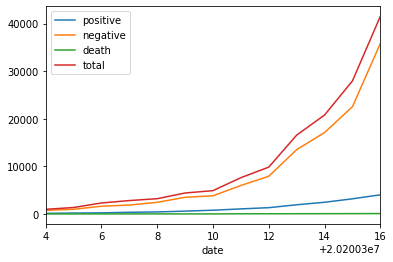

In [16]:
gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

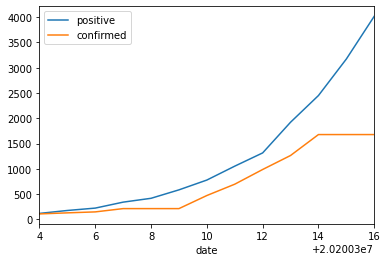

In [17]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [18]:
gbCA.sum().sort_values(by='date')

,positive,negative,pending,death,total
date,,,,,
20200304,53,462,0,0,515
20200305,53,462,0,0,515
20200306,60,462,0,0,522
20200307,69,462,0,0,531
20200308,88,462,0,0,550
20200309,114,690,0,0,804
20200310,133,690,0,0,823
20200311,157,916,0,0,1073
20200312,202,916,0,4,1118


In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-15-2020.csv"
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['state', 'country', 'last_update',
                               'confirmed', 'dead', 'recovered', 'lat','lon'])

In [23]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    3499
dead           63
dtype: int64

In [24]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    426
dead           6
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [26]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
China           81003
Italy           24747
Iran            13938
Korea, South     8162
Spain            7798
Germany          5795
France           4513
US               3499
Switzerland      2200
Norway           1221
Name: confirmed, dtype: int64

In [27]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False)

country
China                             81003
Italy                             24747
Iran                              13938
Korea, South                       8162
Spain                              7798
                                  ...  
Ethiopia                              1
Eswatini                              1
Equatorial Guinea                     1
Congo (Brazzaville)                   1
occupied Palestinian territory        0
Name: confirmed, Length: 147, dtype: int64